<a href="https://colab.research.google.com/github/aymenchibouti/newversion/blob/master/lstm_with_28_features_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (48217, 214)
Dropout rate: 79.29%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
965/965 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7607 - loss: 1.6920 - val_accuracy: 0.8429 - val_loss: 0.6560 - learning_rate: 0.0010
Epoch 2/100
965/965 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8537 - loss: 0.5625 - val_accuracy: 0.8613 - val_loss: 0.4098 - learning_rate: 0.0010
Epoch 3/100
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8587 - loss: 0.4108 - val_accuracy: 0.8620 - val_loss: 0.3796 - learning_rate: 0.0010
Epoch 4/100
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8585 - loss: 0.3850 - val_accuracy: 0.8640 - val_loss: 0.3684 - learning_rate: 0.0010
Epoch 5/100
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8562 - loss: 0.3845 - val_accuracy: 0.8623 - val_loss: 0.3711 - learning_rate: 0.0010
Epoch 6/100
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8567 - loss: 0.3777 - val_accuracy: 0.8607 - val_loss: 0.3683 - learning_rate: 0.0010
Epoch 7/100
965/965 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8550 - loss: 

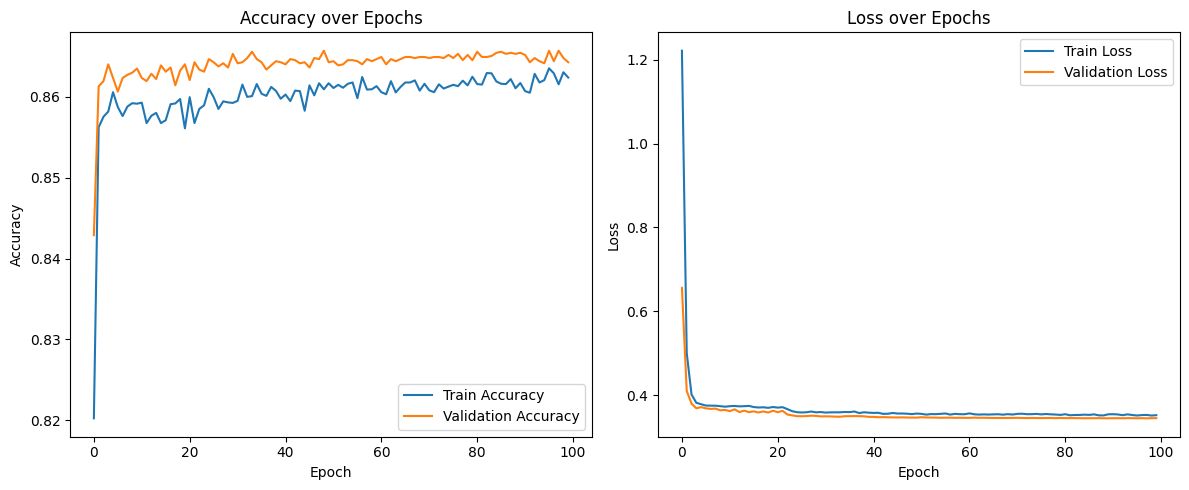

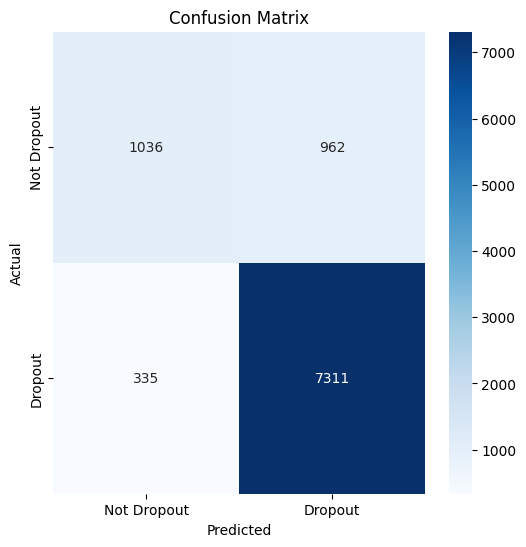

InvalidParameterError: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got <__main__.KerasClassifierWrapper object at 0x7b93a21c4610> instead.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('model1_210_features_spliting.csv')

# Data Exploration
print(f"Dataset shape: {data.shape}")
print(f"Dropout rate: {data['dropout'].mean():.2%}")

# Feature Engineering
# Let's create some aggregate features from the daily activity patterns
activity_columns = [col for col in data.columns if col.startswith('day_')]
daily_features = ['access', 'problem', 'wiki', 'discussion', 'navigate', 'page_close', 'video']

# Create features for each activity type across all days
for feature in daily_features:
    cols = [col for col in activity_columns if feature in col]
    data[f'total_{feature}'] = data[cols].sum(axis=1)
    data[f'active_days_{feature}'] = (data[cols] > 0).sum(axis=1)
    data[f'last_day_{feature}'] = data[[f'day_30_{feature}']].values

# Create overall activity features
data['total_activity'] = data[[f'total_{f}' for f in daily_features]].sum(axis=1)
data['active_days'] = (data[activity_columns] > 0).sum(axis=1)
data['last_week_activity'] = data[[col for col in activity_columns if int(col.split('_')[1]) >= 24]].sum(axis=1)

# Drop the original day-by-day columns to reduce dimensionality
data = data.drop(columns=activity_columns)

# Split into features and target
X = data.drop(columns=['enrollment_id', 'username', 'course_id', 'dropout'])
y = data['dropout']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Architecture
def create_model(input_shape, learning_rate=0.001):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
model = create_model(X_train.shape[1])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_prob = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"\nModel Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Dropout', 'Dropout'],
            yticklabels=['Not Dropout', 'Dropout'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# SOLUTION 1: Create a wrapper class to make Keras model compatible with sklearn
class KerasClassifierWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int).flatten()

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

# Wrap the model
wrapped_model = KerasClassifierWrapper(model)

# Feature Importance (using permutation importance)
from sklearn.inspection import permutation_importance

result = permutation_importance(
    wrapped_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_idx = result.importances_mean.argsort()[::-1]
top_features = 15

plt.figure(figsize=(10, 8))
plt.barh(range(top_features), result.importances_mean[sorted_idx][:top_features][::-1])
plt.yticks(range(top_features), X.columns[sorted_idx][:top_features][::-1])
plt.title("Top Important Features (Permutation Importance)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

Dataset shape: (120542, 214)
Dropout rate: 79.29%
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2411/2411 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.8164 - loss: 1.2404 - val_accuracy: 0.8646 - val_loss: 0.3830 - learning_rate: 0.0010
Epoch 2/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8558 - loss: 0.3918 - val_accuracy: 0.8649 - val_loss: 0.3663 - learning_rate: 0.0010
Epoch 3/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8567 - loss: 0.3789 - val_accuracy: 0.8624 - val_loss: 0.3679 - learning_rate: 0.0010
Epoch 4/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8557 - loss: 0.3777 - val_accuracy: 0.8637 - val_loss: 0.3631 - learning_rate: 0.0010
Epoch 5/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8565 - loss: 0.3777 - val_accuracy: 0.8631 - val_loss: 0.3614 - learning_rate: 0.0010
Epoch 6/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8583 - loss: 0.3721 - val_accuracy: 0.8651 - val_loss: 0.3564 - learning_rate: 0.0010
Epoch 7/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8558 - loss

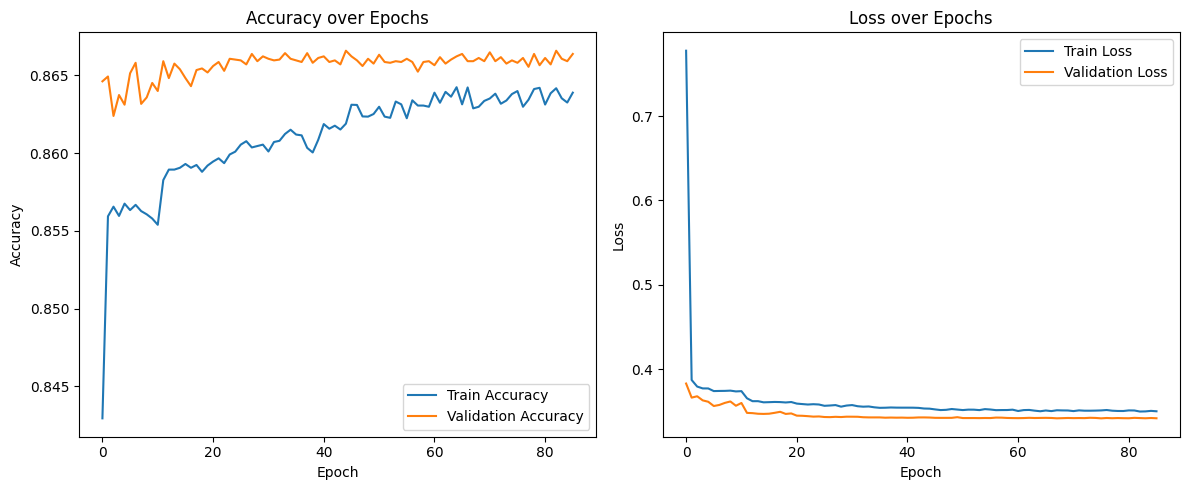

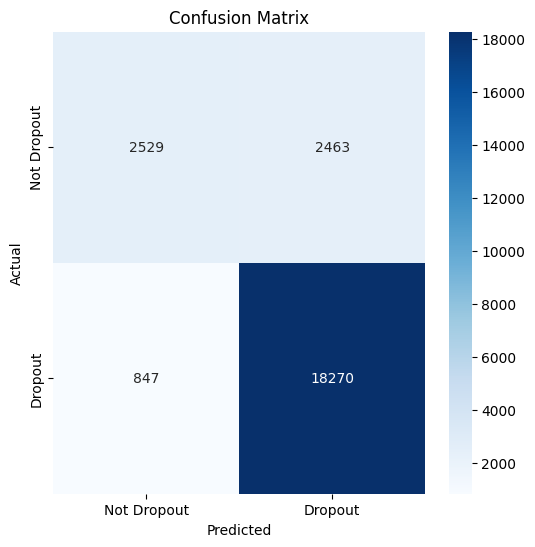

754/754 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


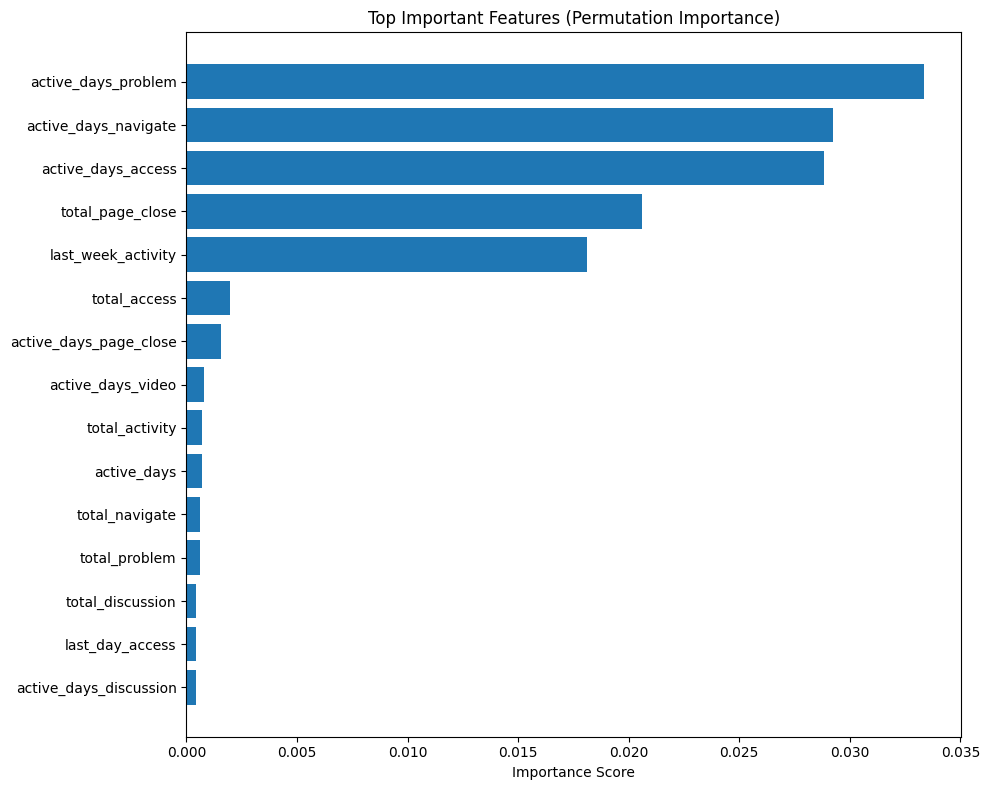

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('model1_210_features.csv')

# Data Exploration
print(f"Dataset shape: {data.shape}")
print(f"Dropout rate: {data['dropout'].mean():.2%}")

# Feature Engineering
# Let's create some aggregate features from the daily activity patterns
activity_columns = [col for col in data.columns if col.startswith('day_')]
daily_features = ['access', 'problem', 'wiki', 'discussion', 'navigate', 'page_close', 'video']

# Create features for each activity type across all days
for feature in daily_features:
    cols = [col for col in activity_columns if feature in col]
    data[f'total_{feature}'] = data[cols].sum(axis=1)
    data[f'active_days_{feature}'] = (data[cols] > 0).sum(axis=1)
    data[f'last_day_{feature}'] = data[[f'day_30_{feature}']].values

# Create overall activity features
data['total_activity'] = data[[f'total_{f}' for f in daily_features]].sum(axis=1)
data['active_days'] = (data[activity_columns] > 0).sum(axis=1)
data['last_week_activity'] = data[[col for col in activity_columns if int(col.split('_')[1]) >= 24]].sum(axis=1)

# Drop the original day-by-day columns to reduce dimensionality
data = data.drop(columns=activity_columns)

# Split into features and target
X = data.drop(columns=['enrollment_id', 'username', 'course_id', 'dropout'])
y = data['dropout']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Architecture
def create_model(input_shape, learning_rate=0.001):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
model = create_model(X_train.shape[1])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_prob = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"\nModel Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Dropout', 'Dropout'],
            yticklabels=['Not Dropout', 'Dropout'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# SOLUTION 1: Create a wrapper class to make Keras model compatible with sklearn
class KerasClassifierWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # This method is required by sklearn but not used in permutation_importance
        # since we're using a pre-trained model
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int).flatten()

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

# Wrap the model
wrapped_model = KerasClassifierWrapper(model)

# Feature Importance (using permutation importance)
from sklearn.inspection import permutation_importance

result = permutation_importance(
    wrapped_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_idx = result.importances_mean.argsort()[::-1]
top_features = 15

plt.figure(figsize=(10, 8))
plt.barh(range(top_features), result.importances_mean[sorted_idx][:top_features][::-1])
plt.yticks(range(top_features), X.columns[sorted_idx][:top_features][::-1])
plt.title("Top Important Features (Permutation Importance)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()